In [1]:
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(car))
suppressPackageStartupMessages(library(effects))
suppressPackageStartupMessages(library(nlme))

# Using GLS in `R`
In the previous part of this lesson, we discussed the theory behind GLS. Now we turn to how GLS is implemented within `R`. We saw some examples of using the `gls()` function from `nlme` last semester. At that point, we only focused on the use of the `weights=` argument with different variance structures (e.g. `varIdent()`, `varPower()` etc.). However, there is also a `correlation=` argument that similarly takes a number of pre-specified correlation structures. We can use these two arguments together to form a final variance-covariance matrix that consists of *both* correlation and heterogenous variance groups. In this part of the lesson, we will explore `gls()` further using a simple repeated measures one-way ANOVA model. We will see examples of using `gls()` on more complex datasets in the workshop this week.

## The GLS One-way ANOVA

### The Data
The `datarium` package contains a dataset called `selfesteem` that contains measurements of a self-esteem score taken at 3 different time points per-subject. We can see how this is structured below

In [2]:
library('datarium')
data('selfesteem')
head(selfesteem)

  id       t1       t2       t3
1  1 4.005027 5.182286 7.107831
2  2 2.558124 6.912915 6.308434
3  3 3.244241 4.443434 9.778410
4  4 3.419538 4.711696 8.347124
5  5 2.871243 3.908429 6.457287
6  6 2.045868 5.340549 6.653224

We can then convert it to long-format to make it suitable for univariate modelling

In [3]:
library('reshape2')

# repeats and number of subjects
t <- 3
n <- dim(selfesteem)[1]

# reshape wide -> long
selfesteem.long <- melt(selfesteem,            # wide data frame
                        id.vars='id',          # what stays fixed?
                        variable.name="time",  # name for the new predictor
                        value.name="score")    # name for the new outcome

selfesteem.long <- selfesteem.long[order(selfesteem.long$id),] # order by ID
rownames(selfesteem.long) <- seq(1,n*t)                        # fix row names
selfesteem.long$id        <- as.factor(selfesteem.long$id)     # convert ID to factor

print(head(selfesteem.long))

  id time    score
1  1   t1 4.005027
2  1   t2 5.182286
3  1   t3 7.107831
4  2   t1 2.558124
5  2   t2 6.912915
6  2   t3 6.308434


Our aim will be to look at different ways of modelling the covariance structure within this dataset, using GLS. In general, because there are 3 repeated measurements, the covariance matrix for each subject will be $3 \times 3$. Because we always assume that the subject are independent, we will be working with a block-diagonal structure of the form

$$
\text{Var}\left(\boldsymbol{\epsilon}\right) = 
\begin{bmatrix}
    \boldsymbol{\Sigma}_{1} & \mathbf{0}              & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \boldsymbol{\Sigma}_{2} & \mathbf{0}              & \cdots & \mathbf{0}              \\
    \mathbf{0}              & \mathbf{0}              & \boldsymbol{\Sigma}_{3} & \cdots & \mathbf{0}              \\
    \vdots                  & \vdots                  & \vdots                  & \ddots & \vdots                  \\          
    \mathbf{0}              & \mathbf{0}              & \mathbf{0}              & \cdots & \boldsymbol{\Sigma}_{n} \\
\end{bmatrix},
$$

where each $\boldsymbol{\Sigma}_{i}$ is an *identical* $3 \times 3$ matrix and each $\mathbf{0}$ is a $3 \times 3$ matrix of zeros. As such, for subject $i$, our decisions centre on how the following matrix is parameterised

$$
\boldsymbol{\Sigma}_{i} = 
\begin{bmatrix}
    \sigma^{2}_{1} & \sigma_{12}    & \sigma_{13}    \\
    \sigma_{12}    & \sigma^{2}_{2} & \sigma_{23}    \\
    \sigma_{13}    & \sigma_{23}    & \sigma^{2}_{3} \\
\end{bmatrix}.
$$

### The `gls()` Syntax
The `gls()` function is part of the `nlme` package and has a syntax very similar to `lm()`. The mean function is specified using the familiar formula syntax, so we can specify additive effects, interactions, polynomials and all the other complicated adjustments to the mean that we saw last semester. From this perspective, `gls()` and `lm()` can be treated as *identical*. Where the two functions differ is on the inclusion of a `weights=` argument and a `correlation=` argument. The `weights=` argument is used to affect the *variance* (the diagonal elements of $\boldsymbol{\Sigma}$), whereas the `correlation=` argument is used to affect the *covariance* (the off-diagonal elements of $\boldsymbol{\Sigma}$). These can either be used *independently*, or *together* depending on the type of covariance structure we want. We can also leave them out entirely, which will give us the same model as `lm()`, but estimated using REML rather than OLS.

In terms of how to use the `weights=` and `correlation=` arguments, they each need to be passed a special function that describes the structure we want the model to fit. These functions then take a `form=` argument that describes how we want that structure to be applied to our specific dataset. To see all the available variance functions, type `?varClasses` at the `R` prompt. Similarly, to see all the available correlation functions, type `?corClasses` at the `R` prompt. We will examine a few of these options below, as well as in the associated workshop.

In terms of specifying a GLS model that is equivalent to the classic repeated measures ANOVA, we can use the syntax

In [4]:
library('nlme')

gls.mod.CS <- gls(score ~ time, correlation=corCompSymm(form= ~ 1|id), data=selfesteem.long)

Here, we have specified *no* `weights=` argument, which means that `gls()` defaults to a single constant variance term. In terms of `correlation=`, we have used the `corCompSymm()` function which, as the name implies, gives us a *compound symmetric* covariance matrix. We will discuss the syntax used in `form=` further below. In brief, this is saying that we want a compound symmetric covariance structure to apply to each subject as a block. So we are implying a block-diagonal variance-covariance matrix, where each subject is a block and the structure within a block is compound symmetric.

So that we do not get distracted by *inference* just yet, we will just examine the model object, rather than calling `summary()`

In [5]:

print(gls.mod.CS)

Generalized least squares fit by REML
  Model: score ~ time 
  Data: selfesteem.long 
  Log-restricted-likelihood: -38.00009

Coefficients:
(Intercept)      timet2      timet3 
   3.140122    1.793820    4.496220 

Correlation Structure: Compound symmetry
 Formula: ~1 | id 
 Parameter estimate(s):
       Rho 
-0.1765313 
Degrees of freedom: 30 total; 27 residual
Residual standard error: 0.8859852 


So, we can see some details about the REML fit at the top, followed by the parameter estimates for the mean function. This is the same as last semester, where `R` has created dummy variables to represent the factor `time`. The first level of `time` has been dropped, so now the `(Intercept)` parameter represents the mean at `time1`, whereas the two slopes represent the *difference* between `time1` and `time2`, and the *difference* between `time1` and `time3`.

Most importantly, is the information *below* this about the estimated correlation structure. So, we have a summary of what we requested followed by the *parameter estimates*. Because a compound symmetric structure consists of only a *single* constant correlation, we have *one* correlation parameter here (labelled `Rho` for the Greek letter $\rho$). So we can see that the constant correlation between time-points has been estimated as $\hat{\rho} = -0.18$. This is important to note because the correlation is *negative*. Remember from last week that under the repeated measures ANOVA, correlation is only allowed to be *positive*. So even though a compound symmetric structure remains a restrictive choice, an advantage of GLS is that it allows for the correlation to be *negative*. 

Another advantage of GLS is that the covariance structure is estimated *explicitly*, rather than simply being *implied* by the algebra of the model. This means we can actually *look* at it. The `nlme` package comes with a function called `getVarCov()` which returns the estimated variance-covariance matrix. Because most of the time this is *block-diagonal* (and consists mainly of zeros), `getVarCov()` will only return a useful chunk of the matrix, rather than the whole thing. To determine which chunk to return, there is an `individual=` option where we give the *label* of whichever subject we want returned. Importantly, this corresponds to the labels of the factor we used to define the blocks. So, we need to refer to the result of calling

In [6]:
levels(selfesteem.long$id)

 [1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10"

Here, the levels are just numbers turned into strings, but your own data may be different. So, if we provide one of the above labels to `getVarCov()` we will get the covariance structure for that single individual. Effectively this is $\hat{\boldsymbol{\Sigma}}_{i}$ for a given subject. For example, the estimated covariance structure for the subject with `id = '1'` is

In [7]:
Sigma.i <- getVarCov(gls.mod.CS, individual='1')
print(Sigma.i)


Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.78497 -0.13857 -0.13857
[2,] -0.13857  0.78497 -0.13857
[3,] -0.13857 -0.13857  0.78497
  Standard Deviations: 0.88599 0.88599 0.88599 


So here we can actually *see* the compound symmetric structure, as all the diagonal elements are the same and all the off-diagonal elements are the same. Though, as highlighted above, the off-diagonal elements are allowed to be *negative*, unlike the repeated measures ANOVA. 

It can also be useful to *visualise* this matrix, to make the structure clearer. To do so, we use the `Matrix` package and convert the output of `getVarCov()` to a `Matrix`. We can then visualise it with the `image` function[^imagefunc-foot].

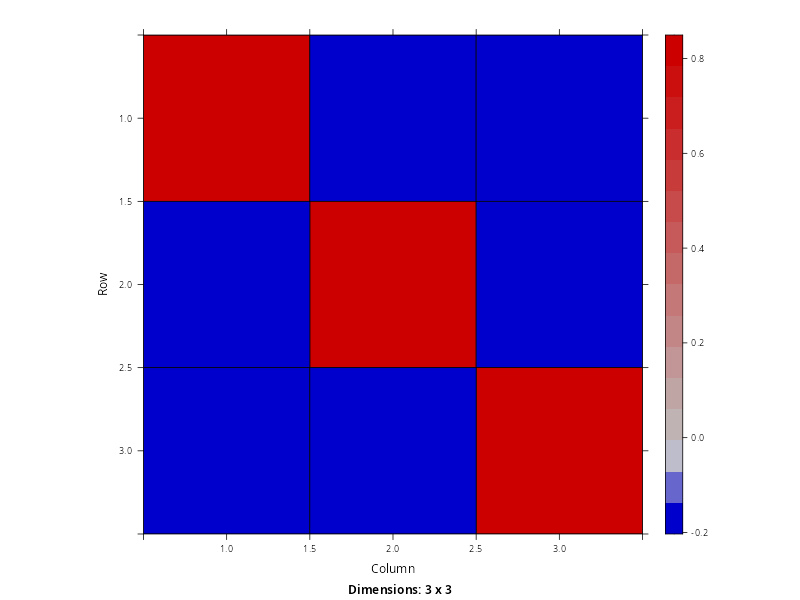

In [8]:
library('Matrix')
image(as(Sigma.i, "Matrix"))

### Understanding the `form=` Syntax
As mentioned above, there are *two* parts to each of the correlation functions we can specify. The first is the actual structure, which is defined by the function itself (e.g. `corCompSymm()`, `corSymm()`, `corAR1()` etc.) The second, is the `form=` argument of that function, which defines how that structure is applied to this specific dataset. The syntax of the `form=` argument can take a little getting used to, but it is worth making an effort to understand because this is *the* way that the application of the given covariance structure is defined. As such, if we want to understand how to *speak* to `gls()` about what we want, we need to understand this.

The first element of `form=` to understand is the vertical bar `|`. This defines the *blocks* in a block-diagonal structure. This is *optional*, so if we do not want a block-diagonal covariance matrix, we do not use this. For repeated measures, we will almost always want this type of structure. To the *right* of the vertical bar is a *factor* whose levels define the blocks. In the example above, we used the factor `id` which has a level per-subject. So the subjects form the blocks. You can think of this as a way of carving up the dataset into specific *rows*. We are effectively saying "take the rows associated with each subject and apply the given covariance structure to those rows".

Sticking with this idea, the value on the *left* of `|` specifies *how* to apply the covariance structure to those rows. If there is nothing else to do and we just want the covariance structure applied to the rows, we just put a `1` here. However, there may be cases where we want the given structure applied in a more complex way. As an example, we will take the `corSymm()` function, because this defines a *completely unstructured* covariance matrix. If we use `corSymm(form= ~ 1|id)`, then we are saying "take the rows associated with each subject and estimate a completely unstructured covariance matrix using those rows". This is fine, so long as we only have *one* measurement per-repeat, because each row then represents a *different condition*. 

However, imagine a situation where we had *replications* of each condition within the data as well[^reps-foot]. For instance, say each subject was measured 4 times at each time-point. In this situation, there is *additional structure* that needs to be included. Here, we can specify `form= ~ time|id`. This still defines a blocked structure, but within each block we are saying that the structure needs to be applied taking the variable `time` into account. To see this visually, the difference between using `corSymm(form= ~ time|id)` and `corSymm(form= ~ 1|id)` is shown below. Hopefully it is clear that one structure is unconstrained, but is using the factor `time` to define the *occasions* over which that unconstrained structure is applied. The other is completely unconstrained, with no notion of `time` as an additional level of structure. The version on the *left* requires only 6 correlation parameters, whereas the version on the right requires 78 correlation parameters.

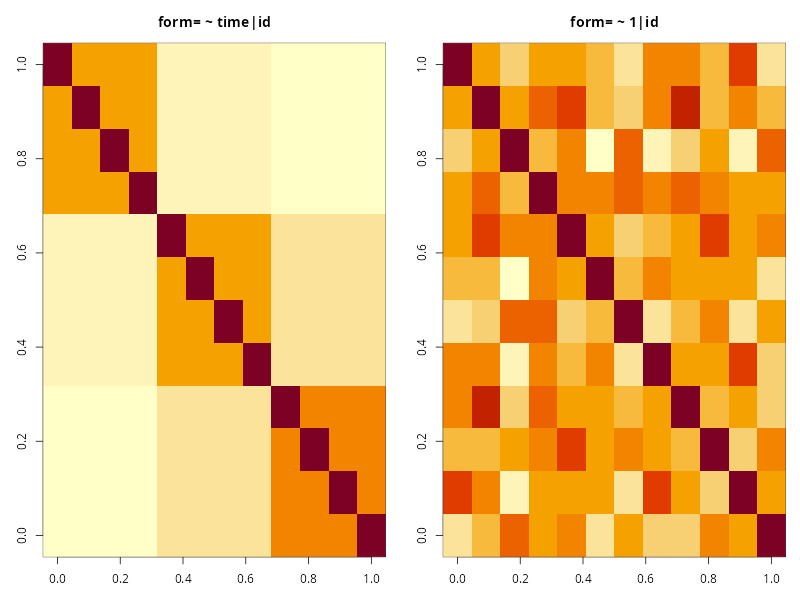

In [9]:
## Same idea as before, but using base graphics throughout

set.seed(1)

Tt   <- 3      # time points
Rrep <- 4      # replicates per time
n    <- Tt * Rrep

## ---- (A) Collapsed by time (what ~ time | id implies) ----
R_time <- matrix(c(
  1.00, 0.30, 0.10,
  0.30, 1.00, 0.20,
  0.10, 0.20, 1.00
), nrow = 3, byrow = TRUE)

rho_within <- c(0.60, 0.55, 0.50)

R_collapsed <- matrix(0, n, n)
time_index <- rep(1:Tt, each = Rrep)

for (ti in 1:Tt) {
  for (tj in 1:Tt) {
    ii <- which(time_index == ti)
    jj <- which(time_index == tj)

    if (ti == tj) {
      B <- matrix(rho_within[ti], Rrep, Rrep)
      diag(B) <- 1
      R_collapsed[ii, jj] <- B
    } else {
      R_collapsed[ii, jj] <- R_time[ti, tj]
    }
  }
}

## ---- (B) Fully unstructured across rows (~ 1 | id) ----
A <- matrix(rnorm(n * n), n, n)
S <- A %*% t(A)
R_unconstrained <- cov2cor(S)

## ---- Plot side-by-side with base graphics ----
par(mfrow = c(1, 2), mar = c(3, 3, 3, 1))

graphics::image(R_collapsed[n:1, ],
                main = "form= ~ time|id",
                xlab = "obs", ylab = "obs")

graphics::image(R_unconstrained[n:1, ],
                main = "form= ~ 1|id",
                xlab = "obs", ylab = "obs")


Note that the effect of this syntax will depend upon the *type* of structure used. For instance, `corCompSymm()` will ignore anything other than a `1` on the left-hand side of `|`, because a compound symmetric structure only has a single correlation for all observations within a block. You *can* type `corCompSymm(form= ~ time|id)`, but it will not do anything. So, you need to think about the *structure* you are using, how the *blocks* are defined for that structure and then how that structure is defined *within* a block.

### Specifying a Fully Unconstrained Covariance Structure
In the example above, we stuck to the restrictive assumptions of the repeated measures ANOVA and specified a covariance structure that was *compound symmetric*. Although slightly advantageous, because we allowed for negative correlation, the whole point of the GLS framework is that we can lift this assumption entirely and specify something more complex. So, we will now consider a *completely unconstrained* covariance structure, where all correlations *and* all variances are free to vary. Note that this is the *opposite extreme* to the repeated measures ANOVA. There may well be a more appropriate structure available that is somewhere in between. For now, we will just focus on the unconstrained structure. In the accompanying workshop, we will examine some alternatives as well as how to use *model comparisons* to choose between them.

In order to specify a completely unconstrained structure, we need to combine both the `correlation=` option and the `weights=` option. Both of these take a `form=` argument, structured in the same way as above. For the correlation, we can use `corSymm(form= ~ 1|id)`. This specifies a block-diagonal correlation structure, where each block consists of a completely unstructured correlation matrix. Because we have no replications within the repeated measurements, we need no additional structure beyond just providing a `1` on the left of `|`. 

For the variance, we can use `varIdent(form= ~ 1|time)`. The `varIdent()` function defines a *constant* variance. If we leave this with *no* `form=` argument, it will do nothing different to a normal linear model with a single variance term. However, we can use `form=` to specify a blocked structure where a *different* constant variance is estimated separately within each block. By specifying `form= ~ 1|time`, we are effectively saying "take the rows associated with each time point separately and estimate a constant variance". This allows each time point to have a separate variance, which means that the diagonal elements of the covariance structure can also vary. 

The full model is therefore

In [10]:
gls.mod.UC <- gls(score ~ time, 
                  correlation =  corSymm(form= ~ 1|id), 
                  weights     = varIdent(form= ~ 1|time), 
                  data        = selfesteem.long)

with an output given by

In [11]:
print(gls.mod.UC)

Generalized least squares fit by REML
  Model: score ~ time 
  Data: selfesteem.long 
  Log-restricted-likelihood: -34.17924

Coefficients:
(Intercept)      timet2      timet3 
   3.140122    1.793820    4.496220 

Correlation Structure: General
 Formula: ~1 | id 
 Parameter estimate(s):
 Correlation: 
  1      2     
2 -0.267       
3  0.361 -0.523
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | time 
 Parameter estimates:
      t1       t2       t3 
1.000000 1.564082 2.070649 
Degrees of freedom: 30 total; 27 residual
Residual standard error: 0.5518062 


where we can see both the 3 correlation parameters that have been estimated, as well as the 3 variance parameters that have been estimated. We can then view and visualise the individual covariance structures as before

Marginal variance covariance matrix
         [,1]     [,2]     [,3]
[1,]  0.30449 -0.12729  0.22736
[2,] -0.12729  0.74489 -0.51578
[3,]  0.22736 -0.51578  1.30550
  Standard Deviations: 0.55181 0.86307 1.1426 


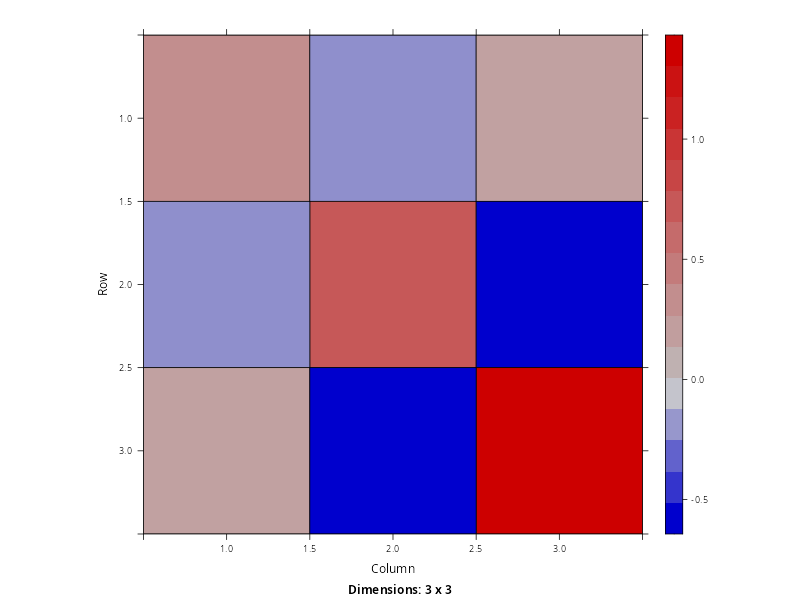

In [12]:
Sigma.i <- getVarCov(gls.mod.UC, individual='1')
print(Sigma.i)
image(as(Sigma.i, "Matrix"))

So, we can see how this syntax has allowed *both* the correlation to be unconstrained and the variances to be unconstrained. This is the *most general* covariance structure we can have for this dataset and thus represents the *most flexible* alternative to the repeated measures ANOVA.

## Inference Using `gls()`
Although at this point we should assess the assumptions of the GLS model, we will leave this to one side and come back to it during the workshop this week. Our focus for now is the thorny topic of *inference* using a `gls()` model. Before digging into this, you may want to quickly remind yourself of the "solutions" discussed earlier in this lesson. Our aim here is to indicate which of these solutions are available within the various functions we have used previously when models were fit with `lm()`.

### Coefficient Tests
To start of with, we will examine the inferential tests provided when we call `summary()` on a `gls()` model object. Using the one-way ANOVA model with the unconstrained covariance structure, we have

In [16]:
summary(gls.mod.UC)

Generalized least squares fit by REML
  Model: score ~ time 
  Data: selfesteem.long 
       AIC      BIC    logLik
  86.35848 98.02101 -34.17924

Correlation Structure: General
 Formula: ~1 | id 
 Parameter estimate(s):
 Correlation: 
  1      2     
2 -0.267       
3  0.361 -0.523
Variance function:
 Structure: Different standard deviations per stratum
 Formula: ~1 | time 
 Parameter estimates:
      t1       t2       t3 
1.000000 1.564082 2.070649 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 3.140122 0.1744964 17.995335       0
timet2      1.793820 0.3611027  4.967618       0
timet3      4.496220 0.3398979 13.228147       0

 Correlation: 
       (Intr) timet2
timet2 -0.685       
timet3 -0.130 -0.254

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-1.98304032 -0.64457676 -0.05166722  0.65547940  2.29294653 

Residual standard error: 0.5518062 
Degrees of freedom: 30 total; 27 residual

where we now have a table of coefficients, similar in spirit to those from an `lm()` model. However, notice that these are given as $t$-statistics *not* $z$-statistics. So this is *not* asymptotic inference (solution **1b** from earlier). In addition, notice that the `Degrees of freedom` listed at the bottom are calculated as the *total* amount of data ($n \times t = 10 \times 3 = 30$) minus the 3 parameters for the mean function. So, this is *not* using effective degrees of freedom (solution **2** from earlier) because the 6 parameters used to estimate the covariance structure are being *ignored*. So, what `summary()` is doing here is solution **1a**: treating $\boldsymbol{\Sigma}$ as *known* and ignoring everything else.

The key to understanding *why* `summary()` behaves in this way is that the `gls()` function is designed to act *as if* we were using GLS instead of FGLS. Indeed, all of the `weights=` and `correlation=` functions will take values for the parameters so that *pre-specified* structures can be used in the call to `gls()`. This was the *original intent* of the function. The ability to *estimate* the structure from the data (and thus switch to FGLS) was a *practical* inclusion, but not one that `summary()` adjusts for. Once we understand this, the behaviour of `gls()` makes complete sense. However, we need to be mindful of all the consequences of this, as listed earlier in the lesson.

### Omnibus Tests
Although the tests returned by `summary()` are somewhat problematic, the extent to which this matters depends on our intention for the model. As we know from last semester, under a typical ANOVA scheme the individual coefficients tests are not particularly interesting because they depend upon the type of dummy variable scheme used. As such, we tend to rely on *omnibus* tests with specific *follow-up* tests instead. So, for the one-way ANOVA model with an unconstrained covariance structure, we can again turn to `Anova()` from the `car` package to produce our Type II omnibus ANOVA tests.

In [19]:
library('car')
Anova(gls.mod.UC)

Analysis of Deviance Table (Type II tests)

Response: score
     Df  Chisq Pr(>Chisq)    
time  2 249.03  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Notice, however, that this does *not* provide an $F$-statistic with denominator degrees of freedom, so this is neither solution **1a** nor solution **2** from earlier. Instead, `Anova()` relies on *asymptotic* tests for omnibus inference. So, interpreting this test involves accepting that the $p$-value will only be *asymptotically* correct, getting more accurate the larger the sample becomes. In this example, we only have $n = 10$, which should make us very cautious about interpreting this test. However, the $p$-value is *so small* ($p < 0.00000000000000022$) that even if it were *liberal* under small samples, it would have to be *catastrophically liberal* in order for a *non-significant* effect to be *this significant* due to sample size alone. In this case, we probably feel fairly confident that *something* is going on, even under asymptotic assumptions.

### Follow-up Tests

[^imagefunc-foot]: Note that both base `R` and the `Matrix` package have functions called `image`. `R` will usually try to infer which one you want to use (and will usually print a warning about one function being *masked* by another). However, if you want to be *explicit* about this, you can prepend the function with the package name like this: `Matrix::image()` or `graphics::image()`.

[^reps-foot]: This is an unusual situation in psychological experiments, not because replications do not exists (they almost always do) but because psychologists will usually just average-over them as part of the pre-processing of their data. This is a habit that comes *directly* from needing data that fits with the traditional repeated measures ANOVA. However, this is not only unnecessary with modern methods, but is actively *throwing away* information that the model can use. This is perhaps *less important* with GLS, but is potentially *very important* with mixed-effects.